#mount data from Drive

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

In [0]:
%cd 'drive/My Drive/scmb'

In [0]:
!ls

#import libraries 

In [5]:
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
print('done')

done


# load data

In [6]:
# set paths
trn_val_path = 'data/train'
test_path = 'data/test'

# NOTE: can add some more transforms later
# Pytorch default backend for images is Pillow - ToTensor() class 
# automatically converts all images into range [0,1]
transform = transforms.ToTensor()

# load
trn_val_data = datasets.ImageFolder(root=trn_val_path, transform=transform)
test_data = datasets.ImageFolder(root=test_path, transform=transform)

print('done')

done


## set up random samplers for creating training and validation sets

In [7]:
# split data into training and validation sets
val_size = 0.25
num_data = len(trn_val_data)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_data))
trn_idx, val_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
trn_sampler = SubsetRandomSampler(trn_idx)
val_sampler = SubsetRandomSampler(val_idx)

print('done')

done


# create data loaders

In [8]:
# NOTE: data laoders output a 4D tensor -> [batch, channel, height, width]
batch_size = 32

trn_loader = torch.utils.data.DataLoader(trn_val_data, 
                                         batch_size=batch_size, 
                                         sampler=trn_sampler)
val_loader = torch.utils.data.DataLoader(trn_val_data, 
                                         batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size)

print(len(trn_loader.sampler), 
      len(val_loader.sampler), 
      len(test_loader.sampler),
      sep='\n') 
print('done')

1978
659
660
done


## confirm that data loaders are working

images[0].shape: torch.Size([3, 224, 224])
labels[0]: 0


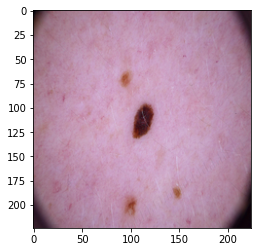

In [13]:
# trn_data
trn_images, trn_labels = next(iter(trn_loader))
print(f'images[0].shape: {trn_images[0].shape}')

# NOTE - class: benign -> 0; malignant -> 1
# can check class label with trn_data.samples
print(f'labels[0]: {trn_labels[0]}')

# Matplotlib requires [height, width, channel]
# images[0] gives a tensor with shape [channels, height, width],
# so need to transpose it 
plt.imshow(np.transpose(trn_images[0].numpy(), (1, 2, 0)))

images[0].shape: torch.Size([3, 224, 224])
labels[0]: 1


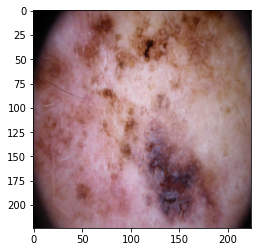

In [14]:
# val_data
val_images, val_labels = next(iter(val_loader))
print(f'images[0].shape: {val_images[0].shape}',
      f'labels[0]: {val_labels[0]}',
      sep='\n')
plt.imshow(np.transpose(val_images[0].numpy(), (1, 2, 0)))

images[0].shape: torch.Size([3, 224, 224])
labels[0]: 0


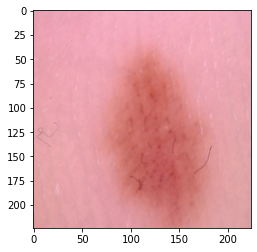

In [15]:
# test_data
test_images, test_labels = next(iter(test_loader))
print(f'images[0].shape: {test_images[4].shape}',
      f'labels[0]: {test_labels[4]}',
      sep='\n')
plt.imshow(np.transpose(test_images[4].numpy(), (1, 2, 0)))

# define model

In [9]:
import torch.nn as nn

# define model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # sees 3x224x224 tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # sees 16x112x112 tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # sees 32x56x56 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # sees 64x28x28 tensor
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # sees 128x14x14 tensor
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)

        self.fc1 = nn.Linear(256*7*7, 1000) 
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        # convolutional layers
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x) # output -> 64x28x28
        x = self.relu(self.conv4(x))
        x = self.maxpool(x) # output -> 128x14x14 
        x = self.relu(self.conv5(x))
        x = self.maxpool(x) # output -> 256x7x7

        # flatten output of conv layers before passing to fc layers
        x = x.view(x.size(0), 256*7*7) 

        # fully connected layers
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # loss fxn applies output layer activation
        return x

print('done')

done


# set up model, loss and optimiser

In [10]:
import torch.optim as optim
# https://pytorch.org/docs/master/generated/torch.nn.BCEWithLogitsLoss.html

model = CNN()

# move model to GPU if it is avaiable
if torch.cuda.is_available():
    model.to('cuda')
    print('model loaded to GPU')

criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

print('done')

model loaded to GPU
done


# train

In [11]:
trn_loss_hx = []
val_loss_hx = []
epochs = 200 

for epoch in range(epochs):

    epoch_trn_loss = 0
    epoch_val_loss = 0
    i = 0

    # training
    model.train()
    for t_images, t_labels in trn_loader:

        if torch.cuda.is_available():
             t_images, t_labels = t_images.to('cuda'), t_labels.to('cuda')

        # clear gradients
        optimiser.zero_grad()
        # forward pass
        t_output = model.forward(t_images)
        # loss
        t_labels = t_labels.type_as(t_output)
        trn_loss = criterion(t_output.squeeze(), t_labels)
        # backprop
        trn_loss.backward()
        # update parameters
        optimiser.step()

        print(epoch, i)
        i+=1
        epoch_trn_loss += trn_loss.item() * t_images.size(0)

    # validation 
    model.eval()
    for v_images, v_labels in val_loader:

        if torch.cuda.is_available():
            v_images, v_labels = v_images.to('cuda'), v_labels.to('cuda')

        # forward pass
        v_output = model.forward(v_images)
        # loss
        v_labels = v_labels.type_as(v_output)
        val_loss = criterion(v_output.squeeze(), v_labels)

        epoch_val_loss += val_loss.item() * v_images.size(0)

    # add epoch losses to hx
    trn_loss_hx.append(epoch_trn_loss / len(trn_loader.sampler))
    val_loss_hx.append(epoch_val_loss / len(val_loader.sampler))

    print(epoch)

print('done')

Streaming output truncated to the last 5000 lines.
120 42
120 43
120 44
120 45
120 46
120 47
120 48
120 49
120 50
120 51
120 52
120 53
120 54
120 55
120 56
120 57
120 58
120 59
120 60
120 61
120
121 0
121 1
121 2
121 3
121 4
121 5
121 6
121 7
121 8
121 9
121 10
121 11
121 12
121 13
121 14
121 15
121 16
121 17
121 18
121 19
121 20
121 21
121 22
121 23
121 24
121 25
121 26
121 27
121 28
121 29
121 30
121 31
121 32
121 33
121 34
121 35
121 36
121 37
121 38
121 39
121 40
121 41
121 42
121 43
121 44
121 45
121 46
121 47
121 48
121 49
121 50
121 51
121 52
121 53
121 54
121 55
121 56
121 57
121 58
121 59
121 60
121 61
121
122 0
122 1
122 2
122 3
122 4
122 5
122 6
122 7
122 8
122 9
122 10
122 11
122 12
122 13
122 14
122 15
122 16
122 17
122 18
122 19
122 20
122 21
122 22
122 23
122 24
122 25
122 26
122 27
122 28
122 29
122 30
122 31
122 32
122 33
122 34
122 35
122 36
122 37
122 38
122 39
122 40
122 41
122 42
122 43
122 44
122 45
122 46
122 47
122 48
122 49
122 50
122 51
122 52
122 53
122 54
12

## plot training and validation loss

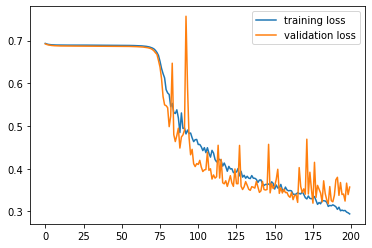

In [12]:
plt.plot(trn_loss_hx, label='training loss')
plt.plot(val_loss_hx, label='validation loss')
plt.legend(loc='upper right')
plt.show()

#assess model accuracy

In [0]:
# recall=(tp)/(tp+fn); precision=(tp)/(tp+fp); F=2(P.R/(P+R))
